In [1]:
# TCC: APLICAÇÃO DE MACHINE LEARNING PARA APOSTAS ESPORTIVAS: uso de Regressão Logística,
#      SVM, Árvore de Decisão e Naive Bayes
#
# Aluno: João Henrique
# Orientadora: Renata Alcoforado

In [2]:
# Importando as bibliotecas

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score , f1_score, precision_score, recall_score
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import  GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
%matplotlib inline

In [3]:
# O arquivo utilizado foi uma compilação com dados baixados do site www.football-data.co.uk, que disponibiliza...
# ... informações de diversos campeonatos ao redor do mundo
# Por meio do Excel foram retirados os jogos em que estavam faltando dados de quaisquer variáveis de interesse...
# ...para o estudo


# Legenda das variáveis:

# Div = Divisão da Liga
# Date = Data do jogo
# HomeTeam = Time da casa
# AwayTeam = Time visitante
# FTR = Resultado do jogo (0 = empate, 1 = vitória do time da casa, 2 = vitória do time visitante)
# B365H = Odd (probablidade) de vitória do time da casa pela Bet365 (casa de apostas)
# B365D = Odd (probablidade) de empate pela Bet365 (casa de apostas)
# B365A = Odd (probablidade) de vitória do time visitante pela Bet365 (casa de apostas)
# BWH = Odd (probablidade) de vitória do time da casa pela Bet&Win (casa de apostas)
# BWD = Odd (probablidade) de empate pela Bet&Win (casa de apostas)
# BWA = Odd (probablidade) de vitória do time visitante pela Bet&Win (casa de apostas)
# IWH = Odd (probablidade) de vitória do time da casa pela Interwetten (casa de apostas)
# IWD = Odd (probablidade) de empate pela Interwetten (casa de apostas)
# IWA = Odd (probablidade) de vitória do time visitante pela Interwetten (casa de apostas)
# PSH = Odd (probablidade) de vitória do time da casa pela Pinnacle (casa de apostas)
# PSD = Odd (probablidade) de empate pela Pinnacle (casa de apostas)
# PSA = Odd (probablidade) de vitória do time visitante pela Pinnacle (casa de apostas)
# VCH = Odd (probablidade) de vitória do time da casa pela VC Bet (casa de apostas)
# VCD = Odd (probablidade) de empate pela VC Bet (casa de apostas)
# VCA = Odd (probablidade) de vitória do time visitante pela VC Bet (casa de apostas)
# WHH = Odd (probablidade) de vitória do time da casa pela William Hill (casa de apostas)
# WHD = Odd (probablidade) de empate pela William Hill (casa de apostas)
# WHA = Odd (probablidade) de vitória do time visitante pela William Hill (casa de apostas)

# Lendo o arquivo ITA10anos.csv
data = pd.read_csv('ITA10anos.csv', delimiter = ',')

# Visualizando a base de dados:
display(data.head())

,Div,Date,HomeTeam,AwayTeam,FTR,B365H,B365D,B365A,BWH,BWD,...,IWA,PSH,PSD,PSA,VCH,VCD,VCA,WHH,WHD,WHA
0,I1,25/08/12,Fiorentina,Udinese,H,2.05,3.2,3.75,2.05,3.30,...,3.40,2.10,3.32,4.13,2.10,3.25,4.00,2.10,3.25,3.60
1,I1,25/08/12,Juventus,Parma,H,1.30,5.0,10.50,1.28,5.00,...,7.30,1.33,5.28,12.27,1.33,5.25,12.00,1.33,4.80,10.00
2,I1,26/08/12,Atalanta,Lazio,A,2.40,3.2,3.00,2.40,3.20,...,2.60,2.47,3.19,3.33,2.45,3.20,3.25,2.50,3.20,2.88
3,I1,26/08/12,Chievo,Bologna,H,2.10,3.2,3.60,2.10,3.15,...,3.20,2.23,3.16,3.92,2.20,3.12,3.90,2.15,3.20,3.60
4,I1,26/08/12,Genoa,Cagliari,H,1.95,3.3,4.00,2.00,3.25,...,3.45,2.03,3.31,4.37,2.05,3.25,4.30,2.10,3.25,3.60


In [4]:
# Criando a coluna com o identificador do jogo (Game_id)

data = pd.DataFrame(data)
data = data.reset_index()
data = data.rename(columns = {"index": "Game_id"})
data["Game_id"] = data.index + 1


# Alterando os resultados de string (D = empate, H = vitória do time da casa, A = vitória do time visitante), para
# int (0 = empate, 1 = vitória do time da casa, 2 = vitória do time visitante)
for i in range(0,len(data)):
    if data["FTR"][i] == "D":
        data.at[i,"FTR"] = "0"
    if data["FTR"][i] == "H":
        data.at[i,"FTR"] = "1"
    if data["FTR"][i] == "A":
        data.at[i,"FTR"] = "2"

data["FTR"] = data["FTR"].astype(str).astype(int)

# Verificando as 5 primeiras linhas do arquivo após os primeiros ajustes
display(data.head())

,Game_id,Div,Date,HomeTeam,AwayTeam,FTR,B365H,B365D,B365A,BWH,...,IWA,PSH,PSD,PSA,VCH,VCD,VCA,WHH,WHD,WHA
0,1,I1,25/08/12,Fiorentina,Udinese,1,2.05,3.2,3.75,2.05,...,3.40,2.10,3.32,4.13,2.10,3.25,4.00,2.10,3.25,3.60
1,2,I1,25/08/12,Juventus,Parma,1,1.30,5.0,10.50,1.28,...,7.30,1.33,5.28,12.27,1.33,5.25,12.00,1.33,4.80,10.00
2,3,I1,26/08/12,Atalanta,Lazio,2,2.40,3.2,3.00,2.40,...,2.60,2.47,3.19,3.33,2.45,3.20,3.25,2.50,3.20,2.88
3,4,I1,26/08/12,Chievo,Bologna,1,2.10,3.2,3.60,2.10,...,3.20,2.23,3.16,3.92,2.20,3.12,3.90,2.15,3.20,3.60
4,5,I1,26/08/12,Genoa,Cagliari,1,1.95,3.3,4.00,2.00,...,3.45,2.03,3.31,4.37,2.05,3.25,4.30,2.10,3.25,3.60


Total de jogos:  3776
Total de colunas:  24
Total de jogos ganhos em casa:  1649
Total de jogos ganhos pelo visitante:  1182
Total de jogos empatados:  945
Percentual de jogos ganhos em casa: 43.67%


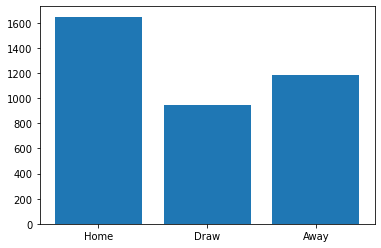

In [5]:
# Explorando a base de dados de dos campeonatos de 2012/2013 a 2021/2022 (últimas 10 temporadas completas)

# Obs.: 24 linhas da base de dados foram retiradas por falta de algumas informações necessárias de variáveis

matches = data.shape[0]
features = data.shape[1]

home_win = len(data[data.FTR==1])
away_win = len(data[data.FTR==2])
draw = len(data[data.FTR==0])
val = [home_win, draw, away_win]

win_rate = (float(home_win)/(matches)) *100

print ('Total de jogos: ', matches)
print ('Total de colunas: ', features)
print ('Total de jogos ganhos em casa: ', home_win)
print ('Total de jogos ganhos pelo visitante: ', away_win)
print ('Total de jogos empatados: ', draw)
print ('Percentual de jogos ganhos em casa: {:.2f}%'.format( win_rate ))

x = np.arange(3)
plt.bar(x, val)
plt.xticks(x, ('Home', 'Draw', 'Away'))
plt.show()

In [6]:
# Separando as features e as labels

features = data[['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA', 'VCH', 'VCD', 'VCA', 'WHH', 'WHD', 'WHA']]
labels = data['FTR']

print('Features')
print(features.head())
print('=====================')
print('Labels')
print(labels.head())

Features
   B365H  B365D  B365A   BWH   BWD    BWA   IWH   IWD   IWA   PSH   PSD  \
0   2.05    3.2   3.75  2.05  3.30   3.90  2.00  3.20  3.40  2.10  3.32   
1   1.30    5.0  10.50  1.28  5.00  11.00  1.35  4.50  7.30  1.33  5.28   
2   2.40    3.2   3.00  2.40  3.20   2.95  2.60  3.10  2.60  2.47  3.19   
3   2.10    3.2   3.60  2.10  3.15   3.60  2.20  3.00  3.20  2.23  3.16   
4   1.95    3.3   4.00  2.00  3.25   3.80  2.00  3.15  3.45  2.03  3.31   

     PSA   VCH   VCD    VCA   WHH   WHD    WHA  
0   4.13  2.10  3.25   4.00  2.10  3.25   3.60  
1  12.27  1.33  5.25  12.00  1.33  4.80  10.00  
2   3.33  2.45  3.20   3.25  2.50  3.20   2.88  
3   3.92  2.20  3.12   3.90  2.15  3.20   3.60  
4   4.37  2.05  3.25   4.30  2.10  3.25   3.60  
Labels
0    1
1    1
2    2
3    1
4    1
Name: FTR, dtype: int32


In [7]:
# Normalizando os dados de entrada (features)

scaler = MinMaxScaler().fit(features)
features_scale = scaler.transform(features)

print('Features: ',features_scale.shape)
print(features_scale)

Features:  (3776, 18)
[[0.0621079  0.07721281 0.07886724 ... 0.06641604 0.14855072 0.07458143]
 [0.01505646 0.24670433 0.28440926 ... 0.01817043 0.26086957 0.26940639]
 [0.08406524 0.07721281 0.05602923 ... 0.0914787  0.14492754 0.05266362]
 ...
 [0.3412798  0.22316384 0.00883069 ... 0.37343358 0.24637681 0.00821918]
 [0.04015056 0.15254237 0.1093179  ... 0.04135338 0.20289855 0.10197869]
 [0.21580928 0.13370998 0.01705238 ... 0.21679198 0.20289855 0.01674277]]


In [8]:
# Separação de treino e teste, feita manualmente para manter a ordem cronológica, uma vez que...
# ... temos informação temporal.
# Treino [:3020]     representa aproximadamente 80% dos dados
# Teste [3020:3398]      representa aproximadamente 10% dos dados
# Previsão [3398:3776]     representa aproximadamente 10% dos dados


X_train = features_scale[:3020]
X_test = features_scale[3020:3398]
y_train = labels[:3020]
y_test = labels[3020:3398]

print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

3020 3020
378 378


In [9]:
# Rodando o modelo de Regressão Logística em sua versão multinomial

clf_LR = LogisticRegression(multi_class = 'multinomial', max_iter = 2000)
clf_LR.fit(X_train, y_train)
pred = clf_LR.predict(X_test)

lr_acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average = 'micro')

print('Regressão Logística')
print('')
print('Acurácia: {:.2f}%'.format(lr_acc*100))
print('F1 Score: {:.2f}%'.format(f1*100))

Regressão Logística

Acurácia: 56.61%
F1 Score: 56.61%


In [10]:
# Rodando o modelo de Support Vector Machine (SVM)

clf_SVM = SVC()
clf_SVM.fit(X_train, y_train)
pred = clf_SVM.predict(X_test)

svm_acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average = 'micro')

print('SVM')
print('')
print('Acurácia: {:.2f}%'.format(svm_acc*100))
print('F1 Score: {:.2f}%'.format(f1*100))

SVM

Acurácia: 56.61%
F1 Score: 56.61%


In [11]:
# Rodando o modelo de Árvore de Decisão

clf_DT = DecisionTreeClassifier(random_state=42)
clf_DT.fit(X_train, y_train)
pred = clf_DT.predict(X_test)

dt_acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average = 'macro')

print('Árvore de Decisão')
print('')
print('Acurácia: {:.2f}%'.format(dt_acc*100))
print('F1 Score: {:.2f}%'.format(f1*100))

Árvore de Decisão

Acurácia: 46.56%
F1 Score: 44.62%


In [12]:
# Rodando o modelo de Naive Bayes

clf_NB = GaussianNB()
clf_NB.fit(X_train, y_train)
pred = clf_NB.predict(X_test)

nb_acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average = 'micro')

print('Naive Bayes')
print('')
print('Acurácia Naive Bayes: {:.2f}%'.format(nb_acc*100))
print('F1 Score: {:.2f}%'.format(f1*100))

Naive Bayes

Acurácia Naive Bayes: 50.26%
F1 Score: 50.26%


In [13]:
#Executando a previsão pelo método de maior acurácia (Regressão Logística)

previsao = features_scale[3398:]

game_id_full = data['Game_id']
game_id_prev = game_id_full[3398:]

res_full = data['FTR']
res_prev = res_full[3398:]

pred = clf_LR.predict(previsao)

df = pd.DataFrame({'Real': res_prev, 'Previsão': pred, 'Game_id': game_id_prev})

print(df)

      Real  Previsão  Game_id
3398     2         1     3399
3399     2         2     3400
3400     2         2     3401
3401     1         1     3402
3402     0         2     3403
...    ...       ...      ...
3771     2         2     3772
3772     1         1     3773
3773     2         2     3774
3774     2         1     3775
3775     0         2     3776

[378 rows x 3 columns]


<AxesSubplot:xlabel='Previsão', ylabel='Real'>

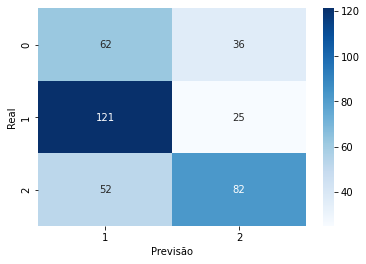

In [14]:
#confusion Matrix

df = pd.DataFrame(df,columns = ['Real','Previsão'])

cf_matrix = pd.crosstab(df['Real'], df['Previsão'], rownames = ['Real'] , colnames = ['Previsão'])

sns.heatmap(cf_matrix, annot = True, cmap = 'Blues', fmt = 'g')